In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

file_dir = os.path.abspath(os.path.dirname(""))
sys.path.append(os.path.join(file_dir, ".."))

from src.utils import load_structured_directory_data

In [11]:
def fix_data(data):
    try:
        if len(data) == 0:
            return np.array([np.float("NaN")])
    except TypeError:
        return np.array([data])

    length = len(data)
    full_acc_index = np.argmax(data == 1.0)
    full_acc_achieved = data[full_acc_index] == 1.0

    if length > 501 or (full_acc_achieved and full_acc_index < length - 1):
        new_data = []
        previous_values = set()
        for index, value in enumerate(data):
            if value not in previous_values:
                previous_values.add(value)
                new_data.append(value)

            if value == 1.0:
                # print("got to 100% acc")
                break

            if len(new_data) > 500:
                # print("max len reached")
                break

        return np.array(new_data)
    else:
        return data

In [28]:
dynamics_path = os.path.abspath(os.path.join(file_dir, "../new_plotting/training"))
root_save_dir = os.path.join(file_dir, "../new_plotting/hypothesis_testing")
temp_dir = os.path.join(file_dir, "temp")

os.makedirs(root_save_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

progress_file_name = "temp_dynamics_paths.npz"
data_file_name = "temp_dynamics_data.npz"
progress_file_path = os.path.join(temp_dir, progress_file_name)
data_file_path = os.path.join(temp_dir, data_file_name)

dynamics_data = load_structured_directory_data(dynamics_path, progress_file_name=progress_file_path, data_file_name=data_file_path, load_data=True, force_rescan=False)

############################################################################
hyper_param_white_list = np.arange(31, 103)
############################################################################

acc_threshold = 0.3

# average data over hyper-parameters
shape = (3, 4, 72, 11)
generalisation_data = np.full(shape, np.float("NaN"))
speed_data = np.full(shape, np.float("NaN"))
area_data = np.full(shape, np.float("NaN"))
d_map = {"mnist": 0, "cifar10": 1, "fashion_mnist": 2}
n_map = {"none 0": 0, "dropout 0.9": 1, "dropout 0.7": 2, "dropout 0.5": 3}

for dataset in dynamics_data:
    dataset_data = dynamics_data[dataset]
    for noise_type in dataset_data:
        noise_type_data = dataset_data[noise_type]
        for noise_level in noise_type_data:
            noise_level_data = noise_type_data[noise_level]
            for hyp_index in noise_level_data:
                if int(hyp_index) not in hyper_param_white_list:
                    continue

                hyp_index_data = noise_level_data[hyp_index]
                for init_index in hyp_index_data:
                    init_index_data = hyp_index_data[init_index]
                    for data_type in init_index_data:
                        data_type_data = init_index_data[data_type]
                        for file_name in data_type_data:
                            if not ("accuracy" in file_name and "test" in file_name):
                                continue

                            data = fix_data(data_type_data[file_name])

                            if len(data) > 0:
                                above_threshold = data >= acc_threshold
                                first_above = np.argmax(above_threshold)
                                if data[first_above] < acc_threshold:
                                    first_above = np.inf

                                data_index = d_map[dataset]
                                noise_index = n_map["{} {}".format(noise_type, noise_level)]
                                generalisation_data[data_index][noise_index][int(hyp_index) - 31][int(init_index)] = np.max(data)
                                speed_data[data_index][noise_index][int(hyp_index) - 31][int(init_index)] = first_above
                                area_data[data_index][noise_index][int(hyp_index) - 31][int(init_index)] = np.sum(data)
                                if not np.all(np.isfinite(data)):
                                    print("oh no")

File exists on disk, simply loading it...
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no


In [29]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

jet = plt.get_cmap('RdYlBu') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

jet = plt.get_cmap('RdYlGn') 
scalarMap1 = cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [30]:
print(scalarMap1.to_rgba(0.9))

(0.09996155324875047, 0.5923875432525951, 0.3118031526336025, 1.0)


In [31]:
generalisation_data = np.mean(generalisation_data, axis=0)
speed_data = np.mean(speed_data, axis=0)
area_data = np.mean(area_data, axis=0)

# generalisation_data = generalisation_data[1, :, :, :]
# speed_data = speed_data[1, :, :, :]
# area_data = area_data[1, :, :, :]

In [32]:
l = []
g = []
s = []
a = []
for init, label in zip(range(11), ["L4", "L3", "L2", "L1", "C", "R1", "R2", "R3", "R4", "E1", "E2"]):
    g_data = generalisation_data[:, :, init].reshape((-1,))
    s_data = speed_data[:, :, init].reshape((-1,))
    a_data = area_data[:, :, init].reshape((-1,))
    g.append(g_data)
    s.append(s_data)
    a.append(a_data)
    l.extend([label for _ in range(g_data.shape[0])])
    
g = np.hstack(g)
s = np.hstack(s)
a = np.hstack(a)

df = pd.DataFrame(dict(l=l, Generalisation=g, Convergence=s, Area=a))
df = df[~np.isnan(df["Generalisation"]) & ~np.isnan(df["Convergence"]) & ~np.isnan(df["Area"])]

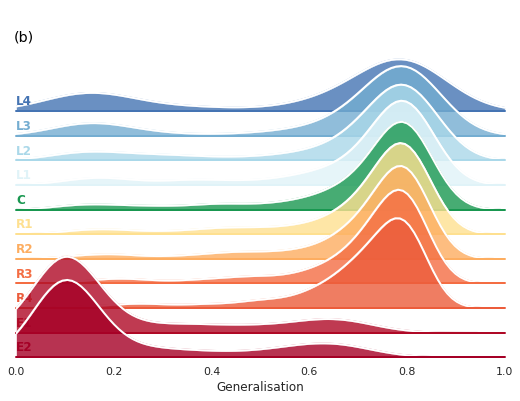

In [33]:
colors = {
    "L4": scalarMap.to_rgba(0.9),
    "L3": scalarMap.to_rgba(0.8),
    "L2": scalarMap.to_rgba(0.7),
    "L1": scalarMap.to_rgba(0.6),
    "C": (0.09996155324875047, 0.5923875432525951, 0.3118031526336025, 1.0),
    "R1": scalarMap.to_rgba(0.4),
    "R2": scalarMap.to_rgba(0.3),
    "R3": scalarMap.to_rgba(0.2),
    "R4": scalarMap.to_rgba(0.175),
    "E1": scalarMap.to_rgba(0.02),
    "E2": scalarMap.to_rgba(0.0)
}

l = sns.FacetGrid(df, row="l", hue="l", aspect=15, height=0.5, palette=colors)

# Draw the densities in a few steps
bins = np.linspace(0, 1, 100)
l.map(sns.distplot, "Generalisation", kde=True, hist=False, bins=bins, kde_kws={"shade": True, "lw": 1.5, "alpha": 0.8, "clip": (0, 1)})
l.map(sns.distplot, "Generalisation", kde=True, hist=False, bins=bins, kde_kws={"shade": False, "lw": 2.0, "color": "w", "clip": (0, 1)})
l.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


l.map(label, "Generalisation")

# Set the subplots to overlap
l.fig.subplots_adjust(hspace=-0.75)
l.fig.text(0.05, 0.88, "(b)", horizontalalignment='left', size='large', color='black')

# Remove axes details that don't play well with overlap
l.set_titles("")
l.set(yticks=[], xlim=[0, 1])
l.despine(bottom=True, left=True)
l.savefig("generalisation.pdf")

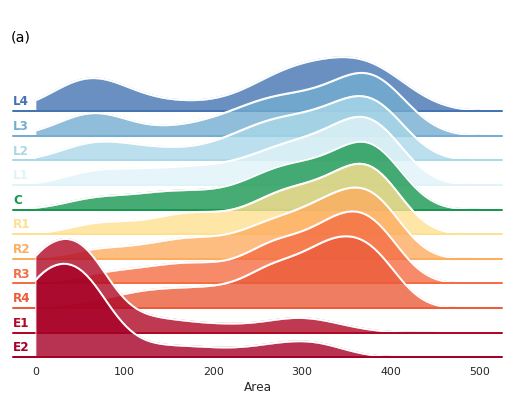

In [34]:
l = sns.FacetGrid(df, row="l", hue="l", aspect=15, height=0.5, palette=colors)

# Draw the densities in a few steps
# bins = np.linspace(0, 1, 100)
l.map(sns.distplot, "Area", kde=True, hist=False, kde_kws={"shade": True, "lw": 1.5, "alpha": 0.8, "clip": (0, 500)})
l.map(sns.distplot, "Area", kde=True, hist=False, kde_kws={"shade": False, "lw": 2.0, "color": "w", "clip": (0, 500)})
l.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


l.map(label, "Area")

# Set the subplots to overlap
l.fig.subplots_adjust(hspace=-0.75)
l.fig.text(0.05, 0.88, "(a)", horizontalalignment='left', size='large', color='black')

# Remove axes details that don't play well with overlap
l.set_titles("")
l.set(yticks=[])
l.despine(bottom=True, left=True)
l.savefig("Area.pdf")

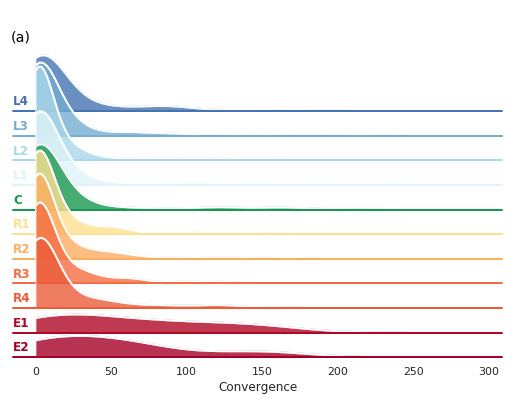

In [35]:
df2 = df[np.isfinite(df["Convergence"])]
l = sns.FacetGrid(df2, row="l", hue="l", aspect=15, height=0.5, palette=colors)

# Draw the densities in a few steps
# bins = np.linspace(0, 1, 100)
l.map(sns.distplot, "Convergence", kde=True, hist=False, kde_kws={"shade": True, "lw": 1.5, "alpha": 0.8, "clip": (0, 300)})
l.map(sns.distplot, "Convergence", kde=True, hist=False, kde_kws={"shade": False, "lw": 2.0, "color": "w", "clip": (0, 300)})
l.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


l.map(label, "Convergence")

# Set the subplots to overlap
l.fig.subplots_adjust(hspace=-0.75)
l.fig.text(0.05, 0.88, "(a)", horizontalalignment='left', size='large', color='black')

# Remove axes details that don't play well with overlap
l.set_titles("")
l.set(yticks=[])
l.despine(bottom=True, left=True)
l.savefig("Convergence.pdf")